# "Forecasting with Statistical Models"
> "statsforecast makes forecasting with statistical models fast & easy"

- toc: true
- branch: main
- badges: true
- comments: true
- categories: [statistics, forecasting, models]
- image: images/nixtla_logo.png

## TL;DR

In this post we present **statsforecast**, an open-source framework from [Nixtla](https://github.com/Nixtla) that makes the use of statistical models in forecasting tasks fast and easy. It allows you to focus on the model instead of implementation details. *statsforecast* is able to handle thousands of time series and is very efficient both time and memory wise.

## Introduction

At Nixtla, [we are creating the world's largest open-source ecosystem for time series forecasting](https://github.com/Nixtla). In this post we will talk about how to use statistical models in forecasting tasks, in particular, we introduce **statsforecast**, a python library that allows to fit statistical models in a simple and computationally efficient way for thousands of time series.

## Motivation

Deep learning and Machine Learning models have demonstrated state-of-the-art performance in time series forecasting tasks. However, it is useful to have a battery of simpler models with which to validate the value added.

In business problems, metrics such as Forecast Value Added (FVA) are usually used to compare the value added of more complex models against techniques that are simpler to implement and explain to decision makers.

A wide range of statistical base models are included in *statsforecast* that can be used for decision making or as benchmarks for the implementation of more complete models.

Also included are models for specific tasks, such as forecasting sparse (or inttermitent) time series, i.e. time series with a high percentage of zero values, such as sales. These particular models exist in implementations for the R programming language but not for Python. 

## statsforecast

To make benchmarking easier, we created [statsforecast](https://github.com/Nixtla/statsforecast), which is a framework to help you forecast time series using statistical models. You just need to give it a model you want to use and let *statsforecast* do the rest.

### Included models

- **ADIDA**: Temporal aggregation is used for reducing the presence of zero observations, thus mitigating the undesirable effect of the variance observed in the intervals. ADIDA uses equally sized time buckets to perform non-overlapping temporal aggregation and predict the demand over a pre-specified lead-time. The time bucket is set equal to the mean inter-demand interval. SES is used to obtain the forecasts. 
- **Croston Classic**: The method proposed by Croston to forecast series that display intermittent demand. The method decomposes the original series into the non-zero demand size and the inter-demand intervals and models them using Simple Exponential Smoothing with a predefined parameter. 
- **Croston SBA**: SBA stands for Syntetos-Boylan Approximation. A variant of the Croston's method that utilizes a debiasing factor.
- **Croston Optimized**: Like Croston, but this model optimizes the Simple Exponential Smoothing for both the non-zero demand size and the inter-demand intervals.
- **Historic average**: Simple average of the time series.
- **iMAPA**: iMAPA stands for Intermittent Multiple Aggregation Prediction Algorithm. Another way for implementing temporal aggregation in demand forecasting. However, in contrast to ADIDA that considers a single aggregation level, iMAPA considers multiple ones, aiming at capturing different dynamics of the data. Thus, iMAPA proceeds by averaging the derived point forecasts, generated using SES. 
- **Naive**: Uses the last value of the time series as forecast. The simplest model for time series forecasting.
- **Random Walk with Drift**: Projects the historic trend from the last observed value.
- **Seasonal Exponential Smoothing**: Adjusts a Simple Exponential Smoothing model for each seasonal period.
- **Seasonal Naive**: Like Naive, but this time the forecasts of the model are equal to the last known observation of the same period in order for it to capture possible weekly seasonal variations.
- **Seasonal Window Average**: Uses the last window (defined by the user) to calculate an average for each seasonal period.
- **SES**: SES stands for Simple Exponential Smoothing. This model recursively weights the most recent observations in the time series. Useful for time series with no trend.
- **TSB**: TSB stands for Teunter-Syntetos-Babai. A modification to Croston's method that replaces the inter-demand intervals component with the demand probability.
- **Window Average**: Uses the last window (defined by the user) to calculate an average.

### Usage

**statsforecast** is available in [PyPI](https://pypi.org/project/statsforecast/) (`pip install statsforecast`).

### Libraries

In [11]:
import random
from itertools import product
from IPython.display import display, Markdown
from multiprocessing import cpu_count

import matplotlib.pyplot as plt
import pandas as pd
from nixtlats.data.datasets.m5 import M5

from statsforecast import StatsForecast
from statsforecast.models import (
    adida, 
    croston_classic, 
    croston_sba, 
    croston_optimized,
    historic_average,
    imapa,
    naive,
    random_walk_with_drift, 
    seasonal_exponential_smoothing,
    seasonal_naive, 
    seasonal_window_average,
    ses, 
    tsb,
    window_average
)

In [3]:
def display_df(df):
    display(Markdown(df.to_markdown()))

### Data

In this example we use the M5 time series competition data. The objective of the competition was to validate models for intermittent demand (sales) data. To download the data we used [nixtlats](https://github.com/Nixtla/nixtlats), a library created by the Nixtla team.

In [4]:
series, *_ = M5.load('data')
horizon = 28

100%|█████████████████████████████████████| 50.2M/50.2M [00:03<00:00, 16.4MiB/s]
INFO:nixtlats.data.datasets.utils:Successfully downloaded m5.zip, 50219189, bytes.
INFO:nixtlats.data.datasets.utils:Decompressing zip file...
INFO:nixtlats.data.datasets.utils:Successfully decompressed data/m5/datasets/m5.zip


The function `M5.load` returns train + test data, so we need to separate them.

In [5]:
series_test = series.groupby('unique_id').tail(horizon).copy()
series = series.drop(series_test.index)

In [6]:
series['unique_id'] = series['unique_id'].astype('object')
series = series.set_index('unique_id')
display_df(series.head())

| unique_id        | ds                  |   y |
|:-----------------|:--------------------|----:|
| FOODS_1_001_CA_1 | 2011-01-29 00:00:00 |   3 |
| FOODS_1_001_CA_1 | 2011-01-30 00:00:00 |   0 |
| FOODS_1_001_CA_1 | 2011-01-31 00:00:00 |   0 |
| FOODS_1_001_CA_1 | 2011-02-01 00:00:00 |   1 |
| FOODS_1_001_CA_1 | 2011-02-02 00:00:00 |   4 |

In [7]:
series.index.unique().shape

(30490,)

This is the required input format.
* an index named **unique_id** that identifies each time series. In this example, we have 30,490 time series.
* a **ds** column with the dates.
* a **y** column with the values.


### Training

We now define the statistical models we will use. We must define a list of functions. If the model has additional parameters, besides the forecast horizon, it must be included as a tuple with the model and the additional parameters.

In [8]:
seasonality = 7 #daily data

In [9]:
models = [
    adida,
    croston_classic,
    croston_sba,
    croston_optimized,
    historic_average,
    imapa,
    naive,
    random_walk_with_drift,
    (seasonal_exponential_smoothing, seasonality, 0.2),
    (seasonal_naive, seasonality),
    (seasonal_window_average, seasonality, 2 * seasonality),
    (ses, 0.1),
    (tsb, 0.3, 0.2),
    (window_average, 2 * seasonality)
    
]

Now we define our trainer, `StatsForecast`, where we define the models we want to use, the frequency of the data and the number of cores used to parallelize the training job.

In this way adjusting these models and generating forecasts is as simple as the following lines.

In [12]:
fcst = StatsForecast(series, models=models, freq='D', n_jobs=cpu_count())
%time forecasts = fcst.forecast(horizon)
display_df(forecasts.head())

INFO:statsforecast.core:Computing forecasts
INFO:statsforecast.core:Computed forecasts for adida.
INFO:statsforecast.core:Computed forecasts for croston_classic.
INFO:statsforecast.core:Computed forecasts for croston_sba.
INFO:statsforecast.core:Computed forecasts for croston_optimized.
INFO:statsforecast.core:Computed forecasts for historic_average.
INFO:statsforecast.core:Computed forecasts for imapa.
INFO:statsforecast.core:Computed forecasts for naive.
INFO:statsforecast.core:Computed forecasts for random_walk_with_drift.
INFO:statsforecast.core:Computed forecasts for seasonal_exponential_smoothing_season_length-7_alpha-0.2.
INFO:statsforecast.core:Computed forecasts for seasonal_naive_season_length-7.
INFO:statsforecast.core:Computed forecasts for seasonal_window_average_season_length-7_window_size-14.
INFO:statsforecast.core:Computed forecasts for ses_alpha-0.1.
INFO:statsforecast.core:Computed forecasts for tsb_alpha_d-0.3_alpha_p-0.2.
INFO:statsforecast.core:Computed forecasts 

CPU times: user 3.08 s, sys: 1.26 s, total: 4.34 s
Wall time: 57.1 s


| unique_id        | ds                  |    adida |   croston_classic |   croston_sba |   croston_optimized |   historic_average |    imapa |   naive |   random_walk_with_drift |   seasonal_exponential_smoothing_season_length-7_alpha-0.2 |   seasonal_naive_season_length-7 |   seasonal_window_average_season_length-7_window_size-14 |   ses_alpha-0.1 |   tsb_alpha_d-0.3_alpha_p-0.2 |   window_average_window_size-14 |
|:-----------------|:--------------------|---------:|------------------:|--------------:|--------------------:|-------------------:|---------:|--------:|-------------------------:|-----------------------------------------------------------:|---------------------------------:|---------------------------------------------------------:|----------------:|------------------------------:|--------------------------------:|
| FOODS_1_001_CA_1 | 2016-05-23 00:00:00 | 0.791852 |          0.898247 |      0.853334 |            0.898247 |           0.786193 | 0.705835 |       0 |              -0.00154639 |                                                   0.981245 |                                0 |                                                 1.35714  |        0.619817 |                      0.402382 |                        0.642857 |
| FOODS_1_001_CA_1 | 2016-05-24 00:00:00 | 0.791852 |          0.898247 |      0.853334 |            0.898247 |           0.786193 | 0.705835 |       0 |              -0.00309278 |                                                   0.483033 |                                0 |                                                 1        |        0.619817 |                      0.402382 |                        0.642857 |
| FOODS_1_001_CA_1 | 2016-05-25 00:00:00 | 0.791852 |          0.898247 |      0.853334 |            0.898247 |           0.786193 | 0.705835 |       0 |              -0.00463918 |                                                   1.09071  |                                0 |                                                 0.785714 |        0.619817 |                      0.402382 |                        0.642857 |
| FOODS_1_001_CA_1 | 2016-05-26 00:00:00 | 0.791852 |          0.898247 |      0.853334 |            0.898247 |           0.786193 | 0.705835 |       0 |              -0.00618557 |                                                   1.37597  |                                1 |                                                 0.357143 |        0.619817 |                      0.402382 |                        0.642857 |
| FOODS_1_001_CA_1 | 2016-05-27 00:00:00 | 0.791852 |          0.898247 |      0.853334 |            0.898247 |           0.786193 | 0.705835 |       0 |              -0.00773196 |                                                   0.592922 |                                0 |                                                 1.07143  |        0.619817 |                      0.402382 |                        0.642857 |

### Visualization

In this section we present visual examples of the forecasts generated.

In [13]:
forecasts = forecasts.reset_index().merge(series_test, how='left', on=['unique_id', 'ds'])

In [14]:
models = forecasts.drop(columns=['unique_id', 'ds', 'y']).columns.to_list()

In [22]:
def plot_grid_prediction(y, y_hat, models, plot_random=True, unique_ids=None):
    """
    y: pandas df
        panel with columns unique_id, ds, y
    y_hat: pandas df
        panel with columns unique_id, ds, y_hat
    models: List[str]
        List of models to plot
    plot_random: bool
        if unique_ids will be sampled
    unique_ids: list
        unique_ids to plot
    """
    pd.plotting.register_matplotlib_converters()

    fig, axes = plt.subplots(2, 2, figsize = (24,8))

    if not unique_ids:
        unique_ids = y['unique_id'].unique()

    assert len(unique_ids) >= 4, "Must provide at least 4 ts"

    if plot_random:
        unique_ids = random.choices(unique_ids, k=4)

    for i, (idx, idy) in enumerate(product(range(2), range(2))):
        y_uid = y[y.unique_id == unique_ids[i]]
        y_uid_hat = y_hat[y_hat.unique_id == unique_ids[i]]

        axes[idx, idy].plot(y_uid.ds, y_uid.y, label = 'y')
        for model in models:
            axes[idx, idy].plot(y_uid_hat.ds, y_uid_hat[model], label=model)
        axes[idx, idy].set_title(unique_ids[i])
        axes[idx, idy].legend(loc='upper left')

    plt.show()

In [23]:
plot_models = random.sample(models, k=4)

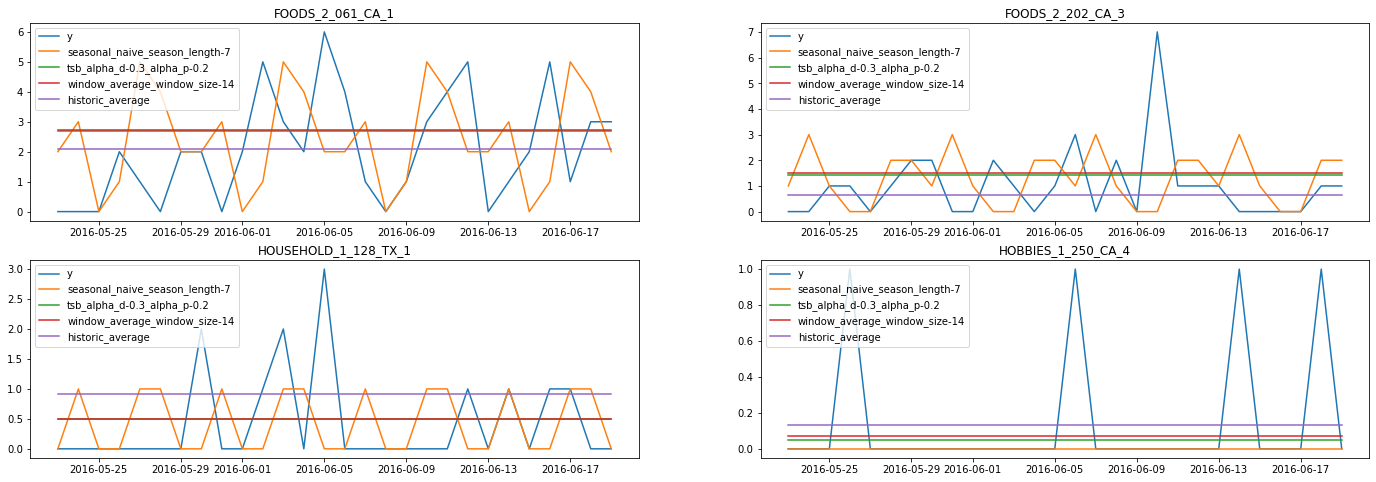

In [26]:
plot_grid_prediction(forecasts[['unique_id', 'ds', 'y']], forecasts[['unique_id', 'ds'] + models], models=plot_models)

## WIP

**statsforecast** is a work in progress. In next releases we plan to include:
- Automated backtesting.
- Ensembles (such as [fforma](https://github.com/FedericoGarza/fforma)).
- More statistical models with exogenous variables.

## Next steps

If you're interested you can learn more in the following resources:
* GitHub repo: https://github.com/Nixtla/statsforecast
* Documentation: https://nixtla.github.io/statsforecast/